In [320]:
# standard 
import os
import datetime as dt

# external
import numpy as np
import pandas as pd

# Stats
from statsmodels.tsa.stattools import adfuller
from scipy.fftpack import fft
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Ploting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-bright')

# Define the palette as a list to specify exact values

palette = sns.color_palette("rocket_r")


In [79]:
df = pd.read_csv("./data/original_data/data.txt", sep = "     ",index_col = None)

<ipython-input-79-6d4dcfed3e20>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv("./data/original_data/data.txt", sep = "     ",index_col = None)


In [80]:
df.head()

,COEF_MAREE UT: 0.0
2000-01-01 12:21:00,48
2000-01-02 00:53:00,50
2000-01-02 13:19:00,53
2000-01-03 01:45:00,56
2000-01-03 14:08:00,60


In [81]:
df.shape

(15292, 1)

In [82]:
df.reset_index(inplace = True)

In [83]:
df.columns

Index(['index', 'COEF_MAREE   UT: 0.0'], dtype='object')

In [84]:
df.rename(columns = {'index':'dateTime', 'COEF_MAREE   UT: 0.0':'coef'}, inplace = True)

In [85]:
df.head()

,dateTime,coef
0,2000-01-01 12:21:00,48
1,2000-01-02 00:53:00,50
2,2000-01-02 13:19:00,53
3,2000-01-03 01:45:00,56
4,2000-01-03 14:08:00,60


In [86]:
df.dtypes

dateTime    object
coef         int64
dtype: object

In [89]:
df['dateTime'] = pd.to_datetime(df['dateTime'])

In [100]:
df['day'] = df['dateTime'].dt.day.values

In [101]:
df['month'] = df['dateTime'].dt.month.values

In [102]:
df['hour'] = df['dateTime'].dt.hour.values

In [104]:
df['year'] = df['dateTime'].dt.year.values

In [144]:
df['time'] = df["dateTime"].dt.time.values

In [146]:
df.head()

,dateTime,coef,date,day,month,hour,year,time
0,2000-01-01 12:21:00,48,2000-01-01,1,1,12,2000,12:21:00
1,2000-01-02 00:53:00,50,2000-01-02,2,1,0,2000,00:53:00
2,2000-01-02 13:19:00,53,2000-01-02,2,1,13,2000,13:19:00
3,2000-01-03 01:45:00,56,2000-01-03,3,1,1,2000,01:45:00
4,2000-01-03 14:08:00,60,2000-01-03,3,1,14,2000,14:08:00


In [122]:
years = df["year"].unique()

In [123]:
df["year"].dtype

dtype('int64')

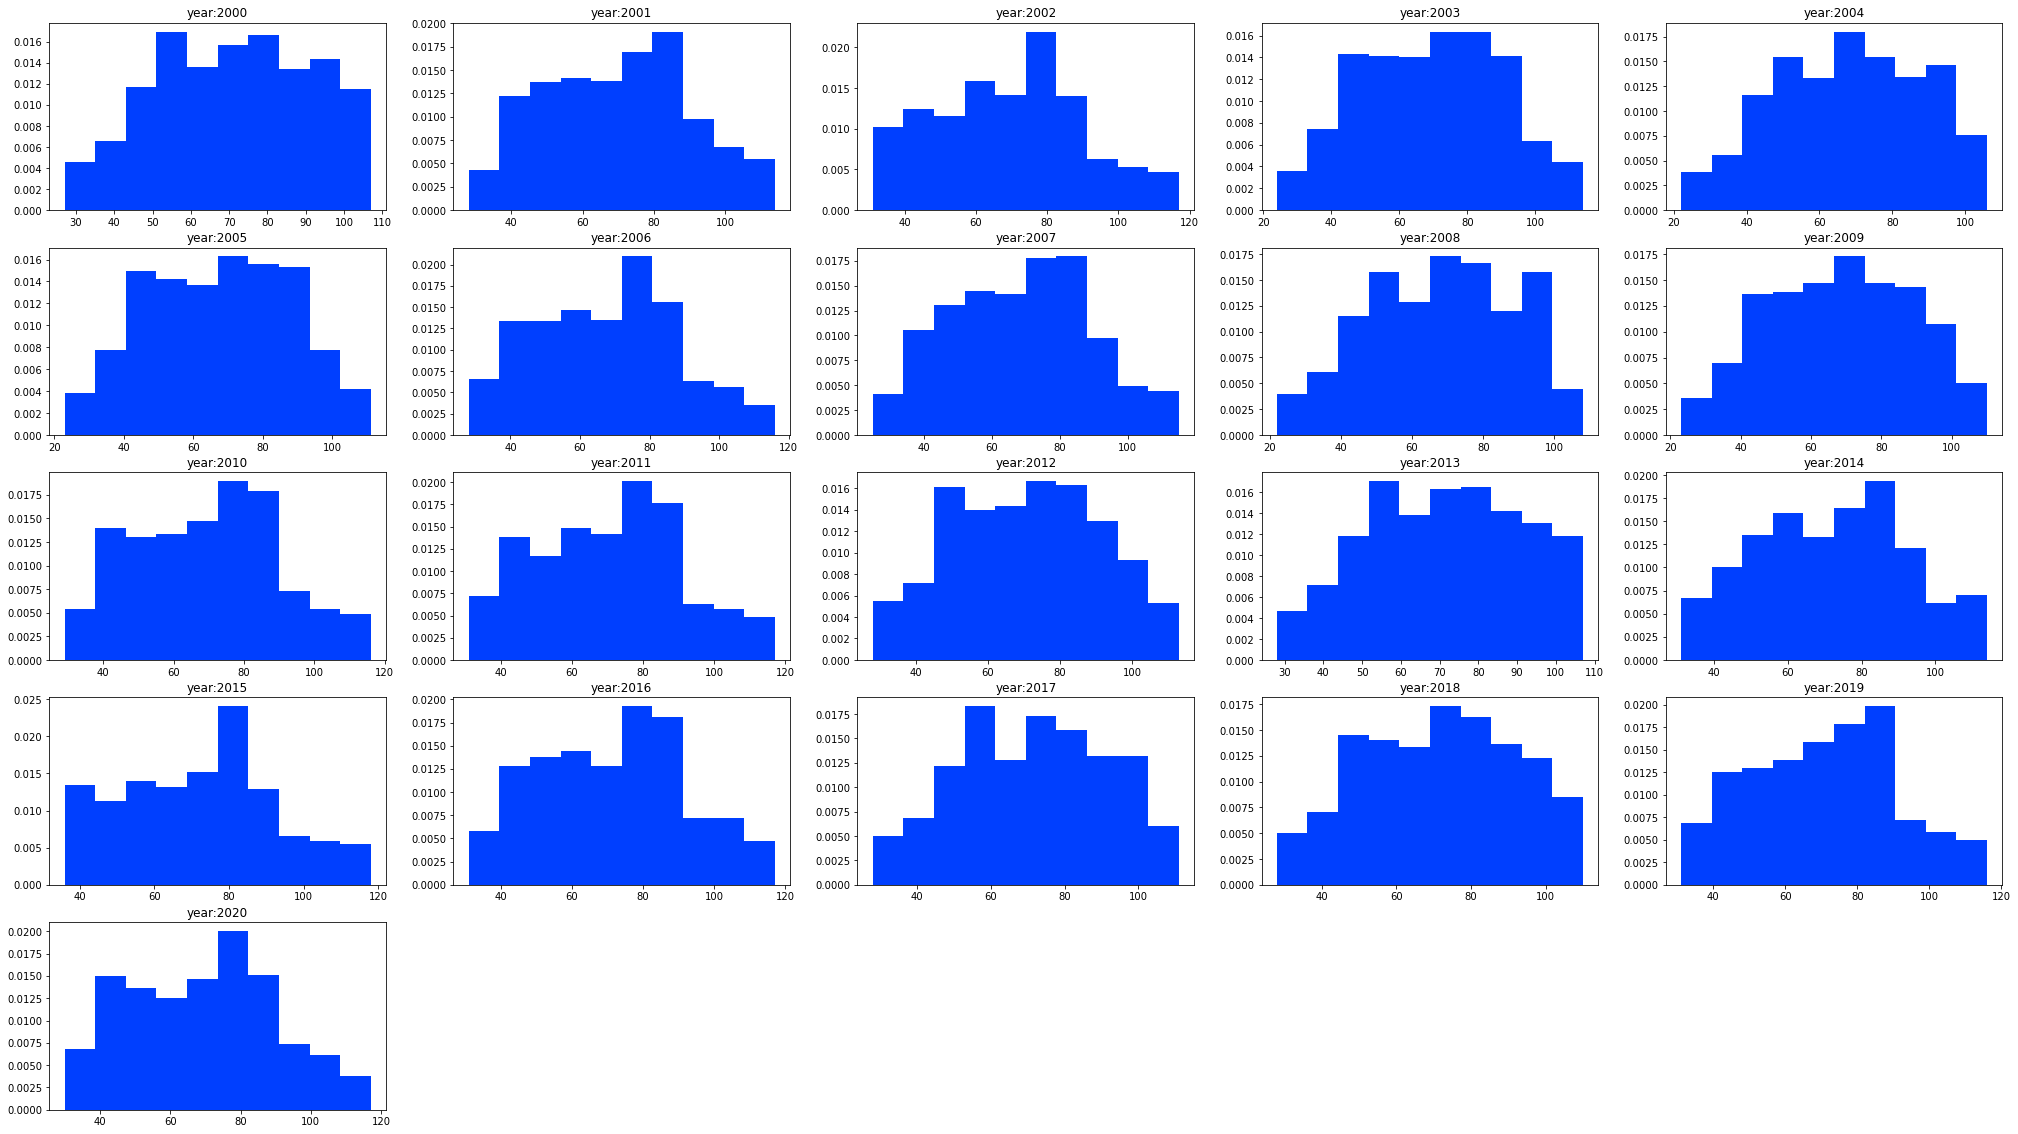

In [262]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.hist(data["coef"], density= True)
    plt.title("year:"+ str(years[i]))

# How does the coefficients change over a given month

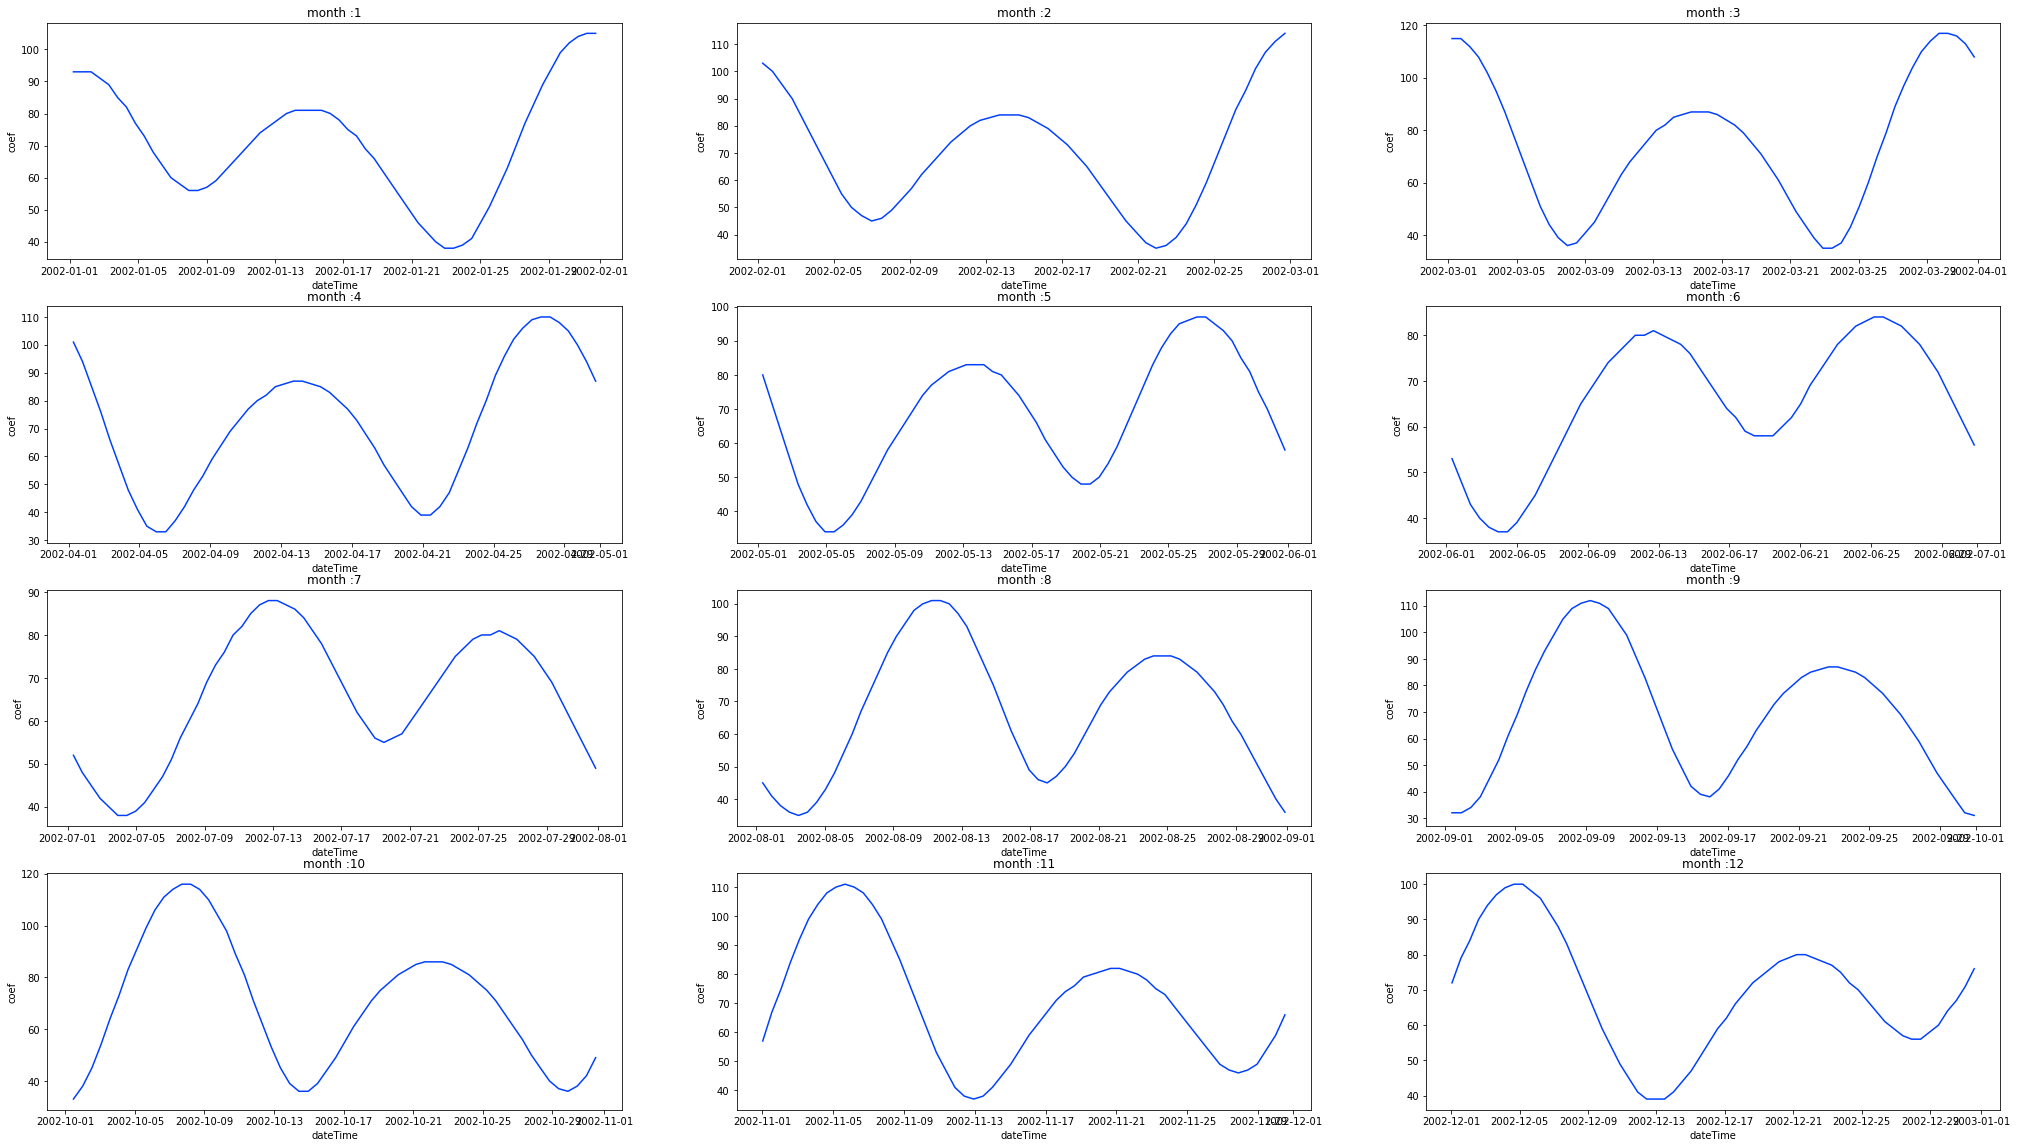

In [267]:
month = np.arange(1,13, 1)
plt.figure(figsize=(35,20))
for i in range(12):
    data = df[df["year"] == 2002]
    data = data[data["month"] == month[i]]
    plt.subplot(4,3,i+1)
    sns.lineplot(x="dateTime", y="coef", data=data)
    plt.title("month :"+ str(month[i]))

# Is there any relation between the variation of coefficients over a given month of two given years?

<ipython-input-237-02a34637ece4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  plt.scatter(df[df["year"]==2001][df["month"]==7]["coef"], df[df["year"]==2002][df["month"]==7]["coef"])


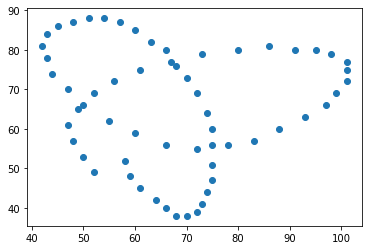

In [237]:
plt.scatter(df[df["year"]==2001][df["month"]==7]["coef"], df[df["year"]==2002][df["month"]==7]["coef"])

Strange??

# Is it stationary?


- When forecasting or predicting the future, most time series models assume that each point is independent of one another. 
    
    The best indication of this is when the dataset of past instances is stationary
- In general, we want to make our serie stationary. 
    Like that we could model the trend and the sesonality. 

    Once these two componantes are modeled we could remove them from the time serie and then train models on the residuals.

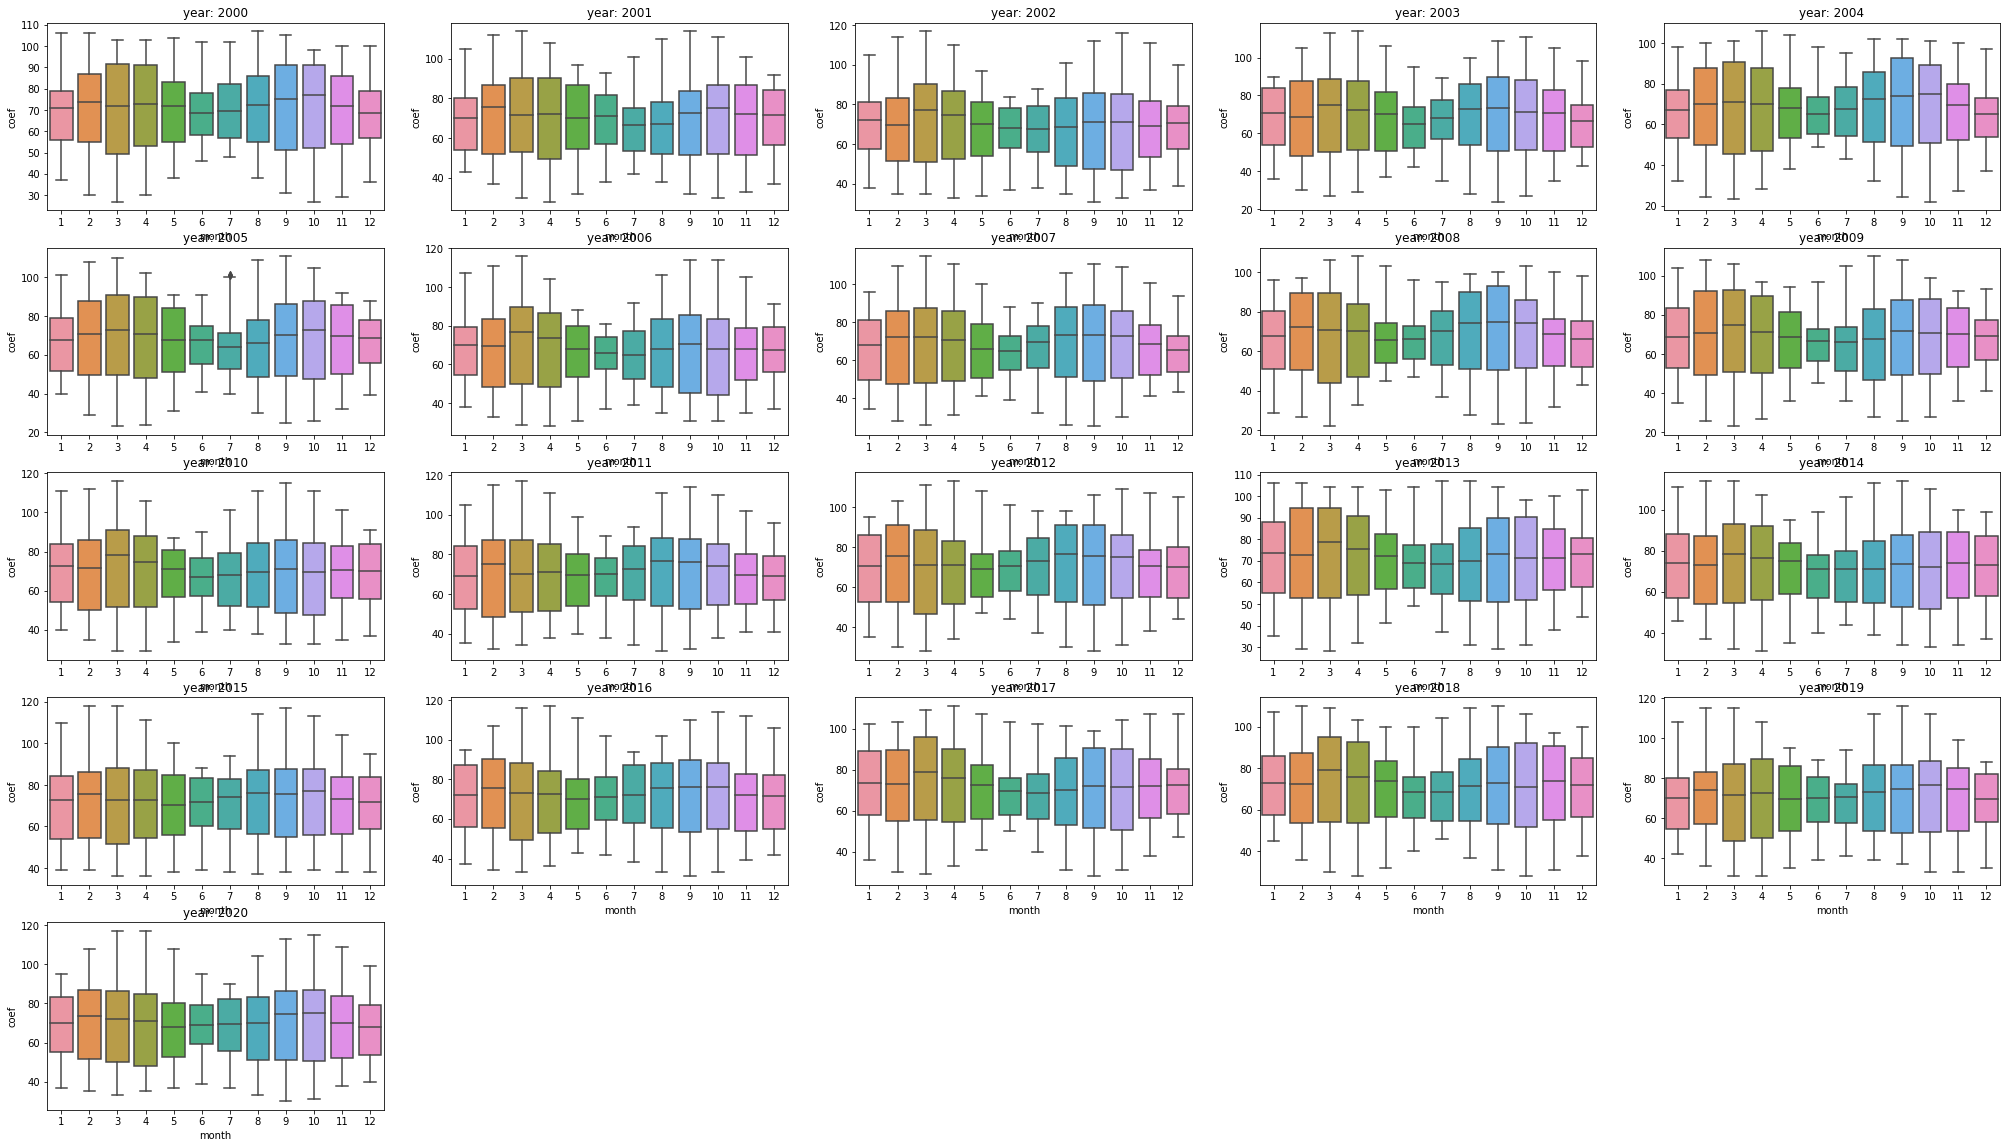

In [264]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    sns.boxplot(x="month", y="coef", data=data)
    plt.title("year: "+ str(years[i]))


- Well since the variance change over time! we would say at this stage it is not stationary 
  Althoug the mean is basically constant !

Let's check using the Dicky-fuller test.

In [248]:
X = df["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -16.416285
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567


the p-value of the test is 0 this suggests the rejection of the null hypothesis, which claims for non-stationarity

- Let's check for only one year

In [250]:
X = df[df["year"]==2020]["coef"].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -7.859436
p-value: 0.000000
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569


So rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

# Is there a seasonality?


Time series datasets can contain a seasonal component.

This is a cycle that repeats over time, such as monthly or yearly. 

This repeating cycle may obscure the signal that we wish to model when forecasting, and in turn may provide a strong signal to our predictive models.

Text(0.5, 1.0, 'year:2000')

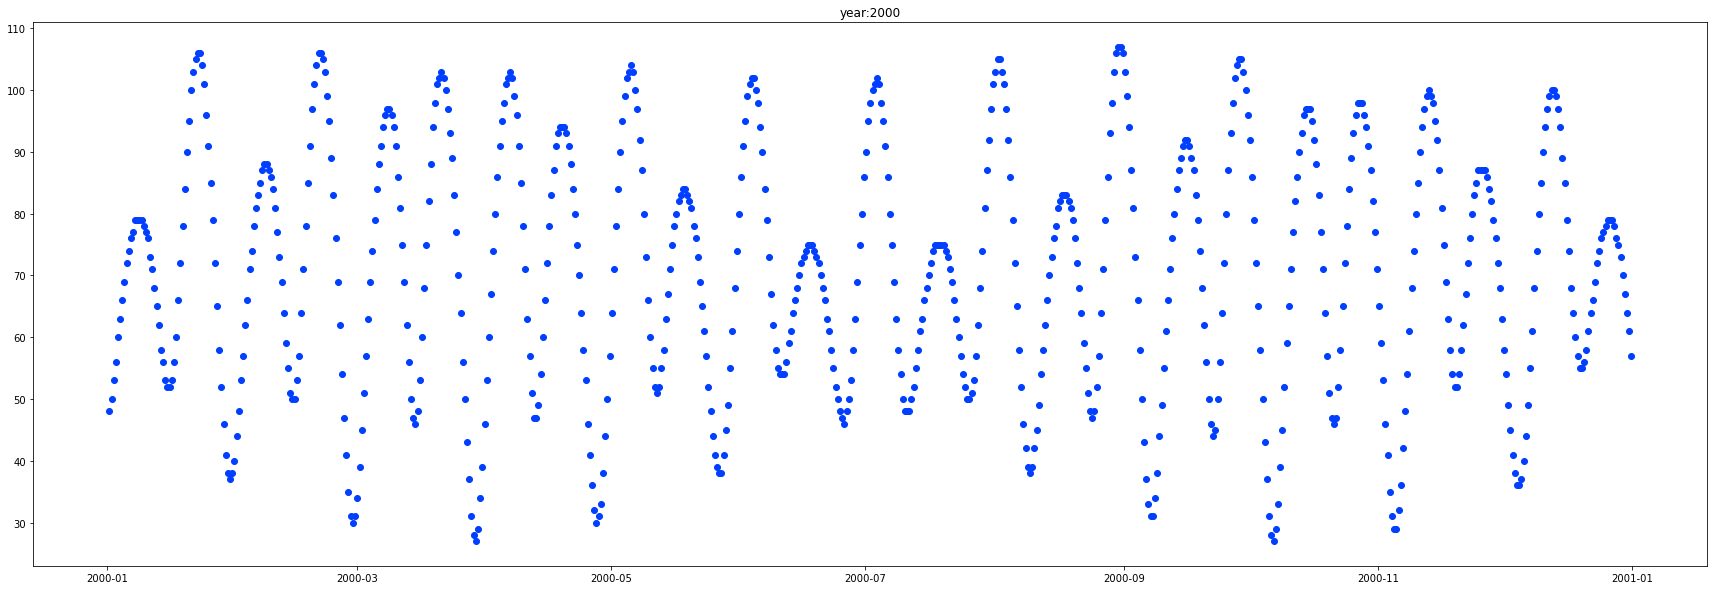

In [304]:
plt.figure(figsize=(30,10))
data = df[df["year"] == 2000]
plt.scatter(data["dateTime"], data["coef"])
plt.title("year:"+ str(2000))

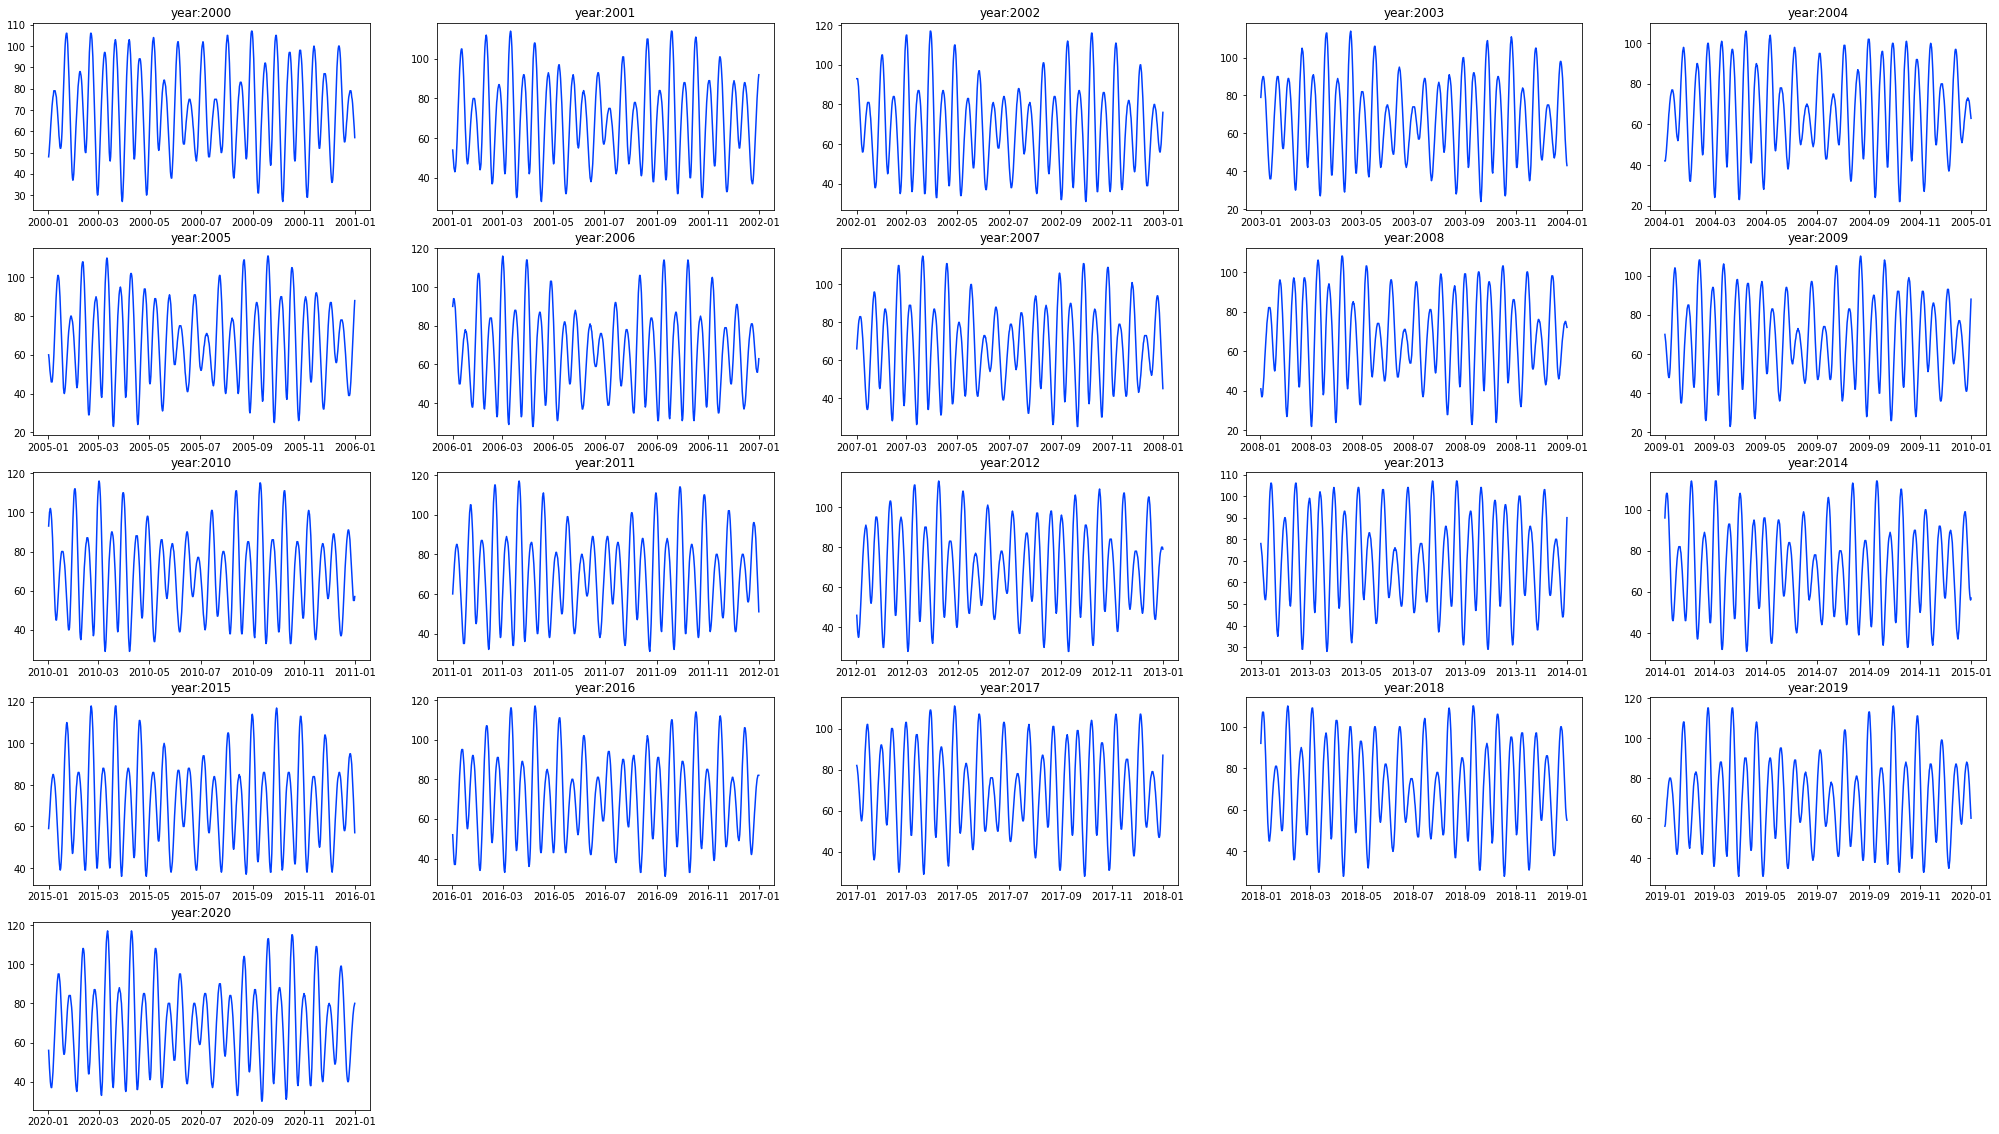

In [265]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["coef"])
    plt.title("year:"+ str(years[i]))

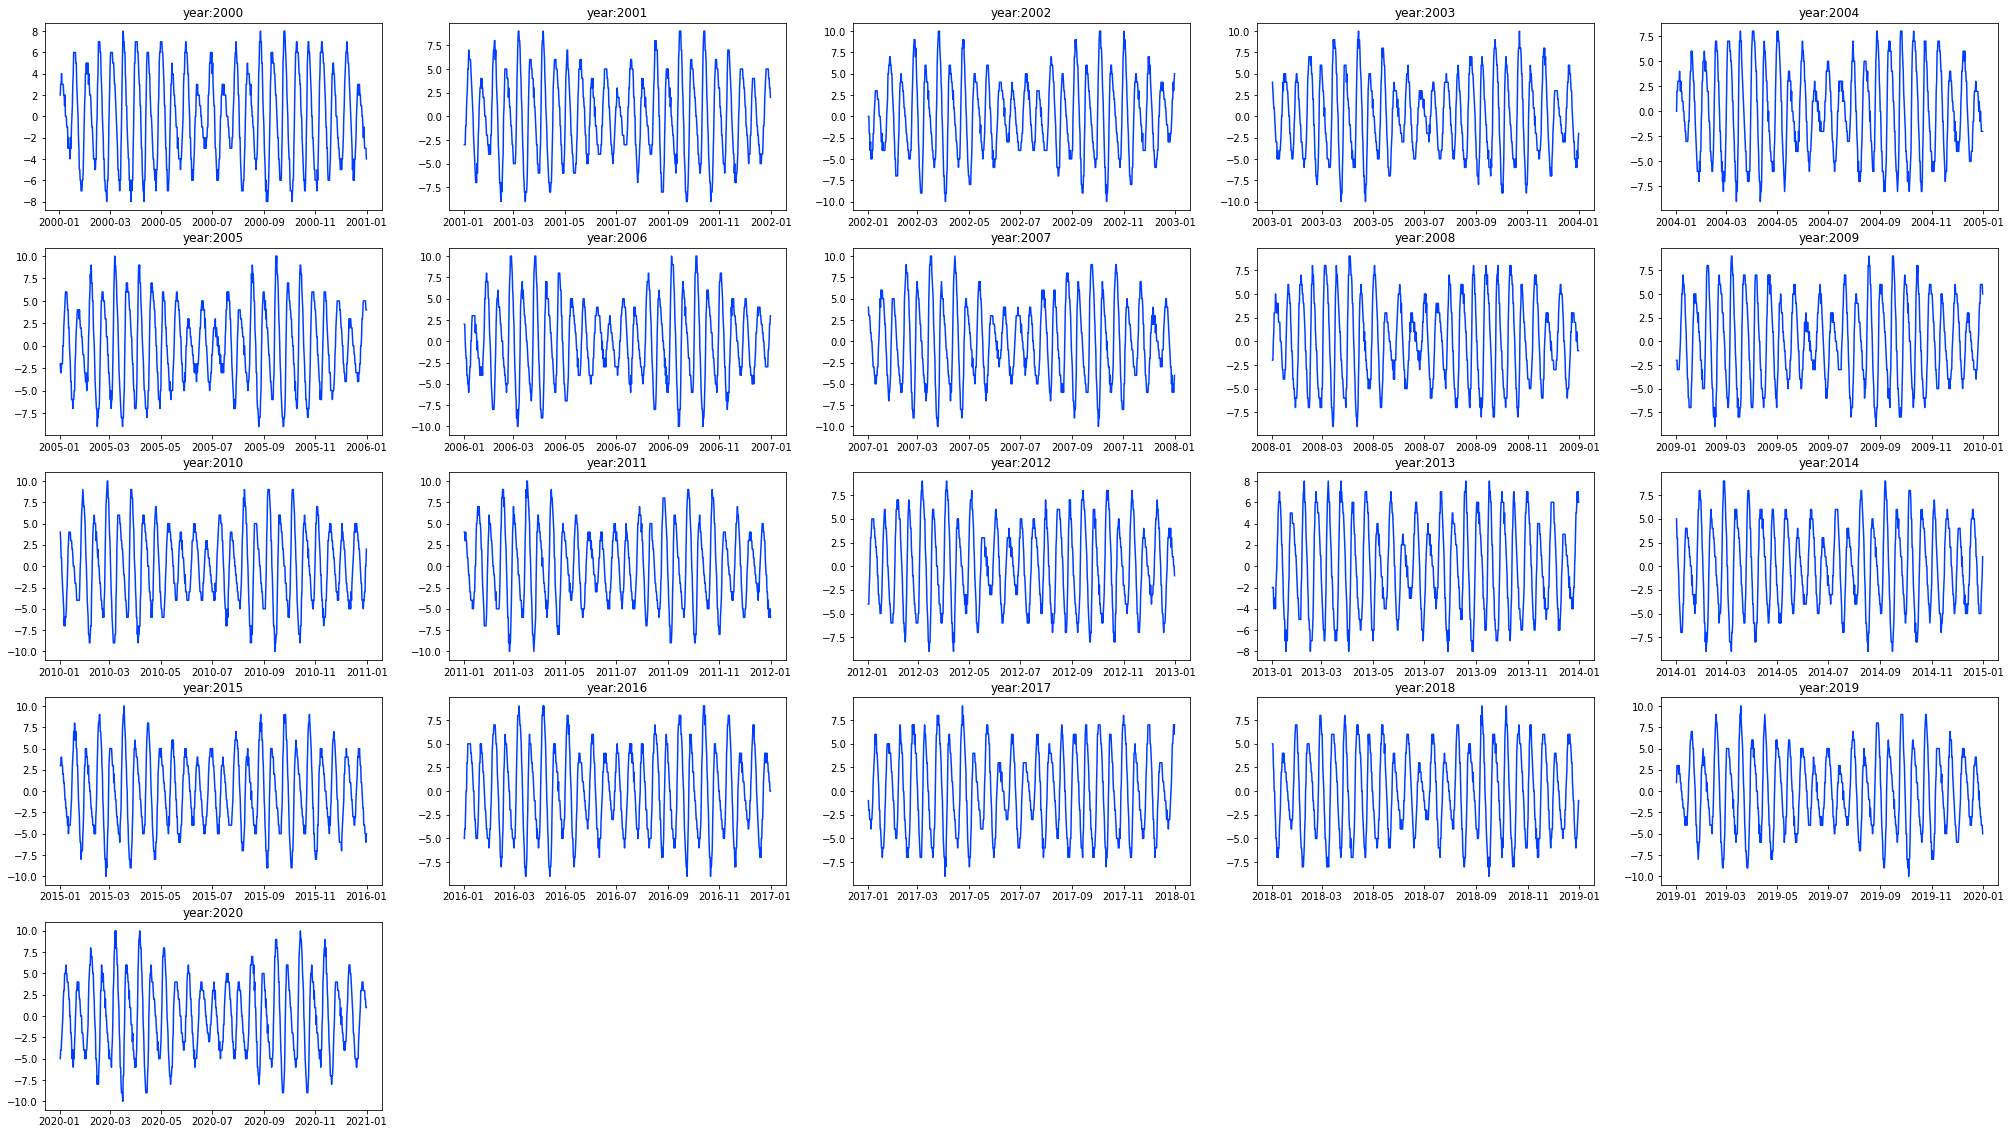

In [300]:
years = np.arange(2000,2021, 1)
plt.figure(figsize=(35,20))
for i in range(21):
    data = df[df["year"] == years[i]]
    plt.subplot(5,5,i+1)
    plt.plot(data["dateTime"], data["coef"].diff())
    plt.title("year:"+ str(years[i]))

Seeing the plots above it seams that there is seasonality (6-month pattern),
but observing the last plot, we could say that our data is seasonal-stationary, let's check by computing the autocorrelation

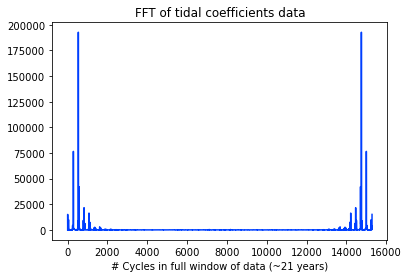

In [283]:
Fft = fft((df.coef - df.coef.mean()).values)
plt.plot(np.abs(Fft))
plt.title("FFT of tidal coefficients data")
plt.xlabel('# Cycles in full window of data (~21 years)');

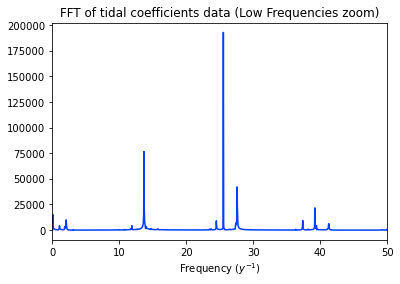

In [314]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([0,50])
plt.xlabel('Frequency ($y^{-1}$)');

- we see that there is a weekly seasonality

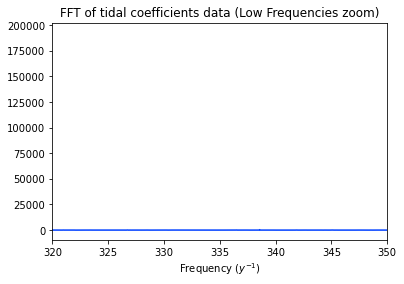

In [312]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([320,350])
plt.xlabel('Frequency ($y^{-1}$)');

- 13 day seasonality

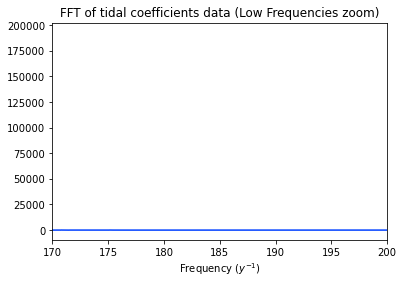

In [311]:
plt.plot(1./21 * np.arange(len(Fft)), np.abs(Fft))
plt.title("FFT of tidal coefficients data (Low Frequencies zoom)")
plt.xlim([170,200])
plt.xlabel('Frequency ($y^{-1}$)');

- no 6 months seasonality

Let's check seasonality by plotting autocorrelation plot

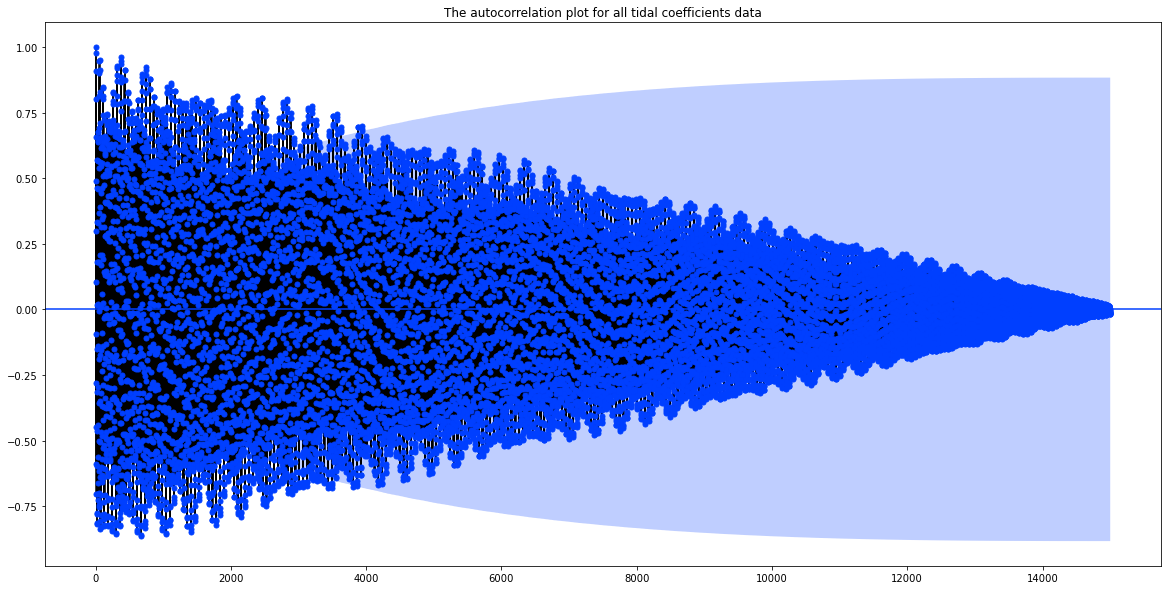

In [335]:
fig, ax = plt.subplots(figsize=(20,10))
plot_acf(df.coef, lags = 15000, ax = ax)
plt.title("The autocorrelation plot for all tidal coefficients data");

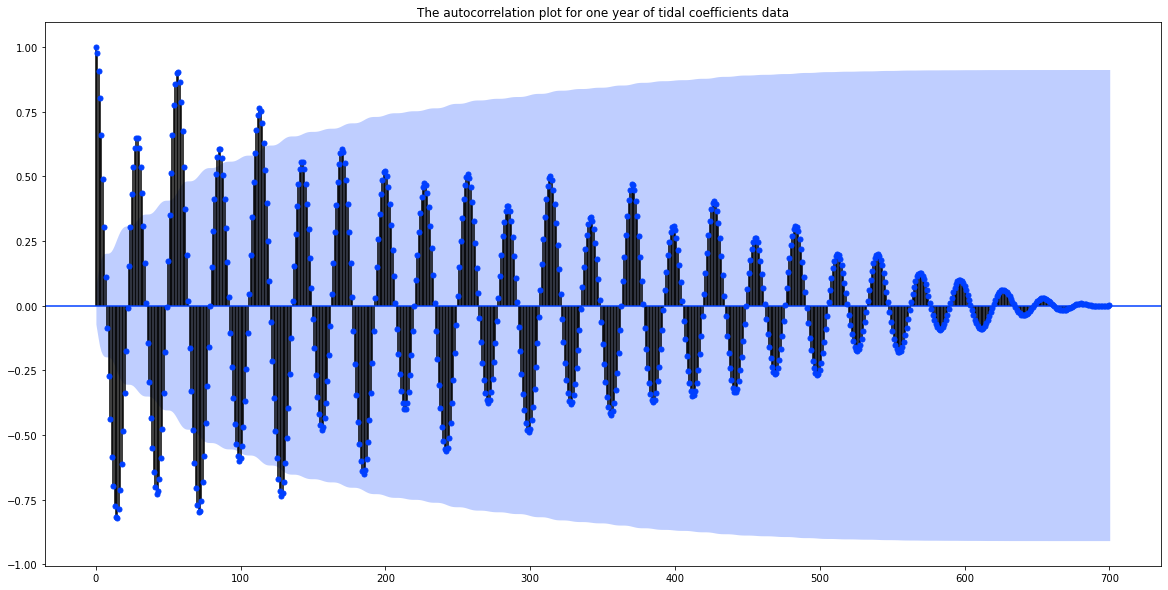

In [336]:
fig, ax = plt.subplots(figsize=(20,10))
plot_acf(df[df["year"]==2000].coef, lags =700, ax = ax)
plt.title("The autocorrelation plot for one year of tidal coefficients data");

C:\Users\Otmane\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


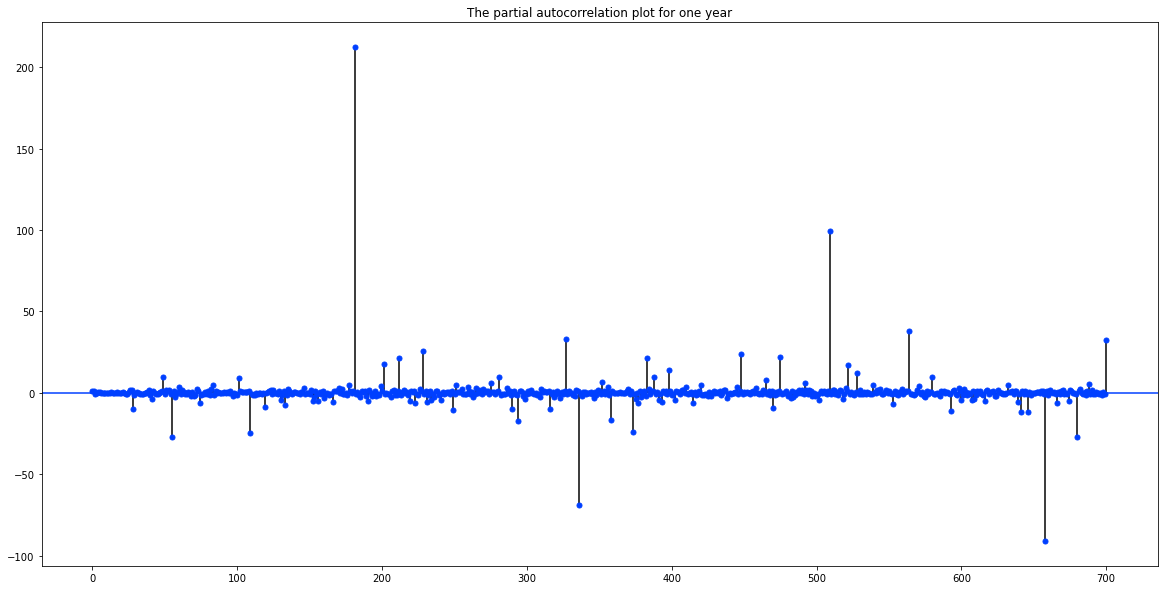

In [334]:
fig, ax = plt.subplots(figsize=(20,10))
plot_pacf(df[df["year"]==2000].coef, lags =700, ax = ax)
plt.title("The partial autocorrelation plot for one year");

we see cycles of strong negative and positive correlation.

This captures the relationship of an observation with past observations in the same and opposite seasons or times of year. 

Sine waves like those seen in this example are a strong sign of seasonality in the dataset.

# Is the target variable autocorrelated?